In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [3]:
import re

def sorted_alphanumeric(data):

    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, low_path, high_path, size = 256):
        self.size = size
        self.low_path = low_path
        self.high_path = high_path
        self.high_files = sorted_alphanumeric(os.listdir(high_path))
        self.low_files = sorted_alphanumeric(os.listdir(low_path))

    def __len__(self):
        return len(self.low_files)


    def __getitem__(self, idx):

        high_img_path = os.path.join(self.high_path, self.high_files[idx])
        low_img_path = os.path.join(self.low_path, self.low_files[idx])

        high_img = cv2.imread(high_img_path, 1)
        high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)
        high_img = cv2.resize(high_img, (self.size, self.size))
        high_img = high_img.astype('float32') / 255.0

        low_img = cv2.imread(low_img_path, 1)
        low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)
        low_img = cv2.resize(low_img, (self.size//4, self.size//4))
        low_img = low_img.astype('float32') / 255.0

        return {
            'high_img': ToTensor()(high_img),
            'low_img': ToTensor()(low_img)
        }

In [5]:
high_res_path = '/content/drive/My Drive/Data/Train set/high_res'
low_res_path = '/content/drive/My Drive/Data/Train set/low_res'
test_high_res_path = '/content/drive/My Drive/Data/Test set/high_res'
test_low_res_path = '/content/drive/My Drive/Data/Test set/low_res'

# Create dataset instance
dataset = ImageDataset(low_res_path, high_res_path)
test_set = ImageDataset(test_low_res_path, test_high_res_path)

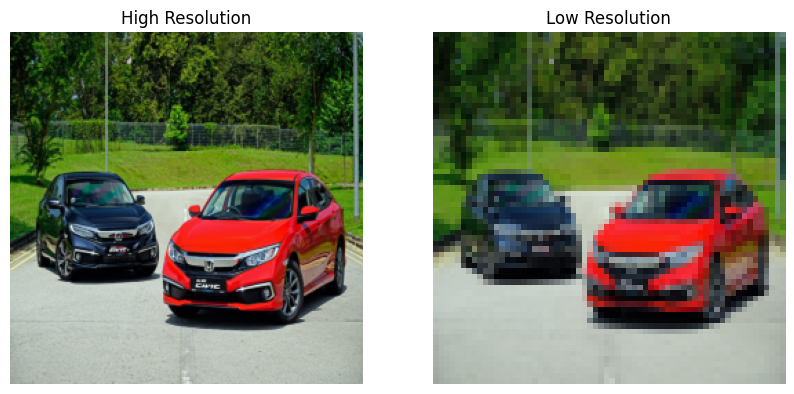

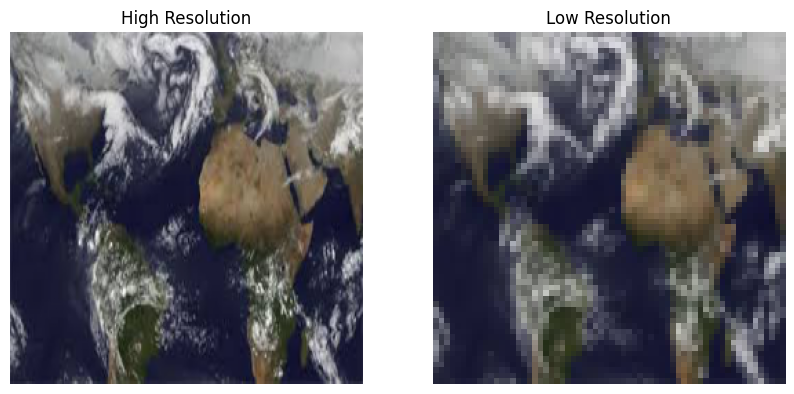

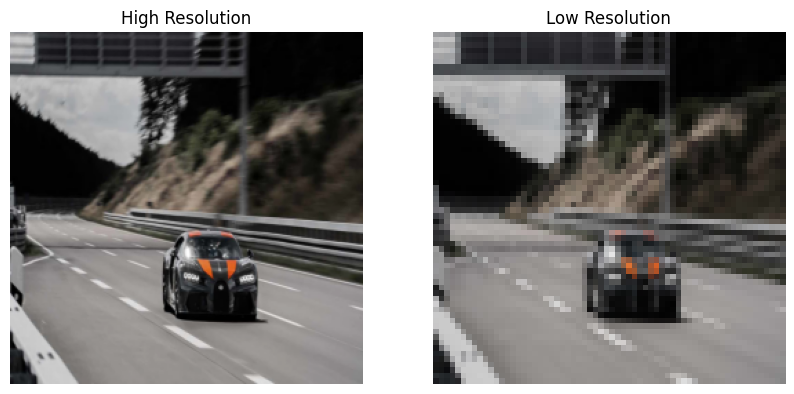

In [6]:
import matplotlib.pyplot as plt
import cv2
num_pairs_to_print = 3

for idx in range(num_pairs_to_print):
    sample = dataset[idx]
    high_img, low_img = sample['high_img'], sample['low_img']
    #Convert the pytorch tensors to numpy arrays
    #Matplotlib expects the images to be in the format : height, width, channels whereas the the pytroch tensor has it in the form of channels, height, width
    #After doing this we convert to the numpy array
    high_img_np = high_img.permute(1, 2, 0).numpy() if high_img.shape[0] == 3 else high_img.numpy()
    low_img_np = low_img.permute(1, 2, 0).numpy() if low_img.shape[0] == 3 else low_img.numpy()

    # Plot high-resolution and low-resolution images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(high_img_np)
    plt.title('High Resolution')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(low_img_np)
    plt.title('Low Resolution')
    plt.axis('off')

    plt.show()


In [7]:
from torch.utils.data import random_split

print("Number of high-resolution images:", len(dataset.high_files))
print("Number of low-resolution images:", len(dataset.low_files))
print("Number of Test high-resolution images:", len(test_set.high_files))
print("Number of Test low-resolution images:", len(test_set.low_files))

train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
# Split the dataset into train, validation sets
train_set, val_set = random_split(dataset, [train_size, val_size])
print("Length of training set is: ", len(train_set))
print("Length of validation set is: ", len(val_set))
print("Length of testing set is: ", len(test_set))


Number of high-resolution images: 360
Number of low-resolution images: 360
Number of Test high-resolution images: 40
Number of Test low-resolution images: 40
Length of training set is:  288
Length of validation set is:  72
Length of testing set is:  40


In [8]:
batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

MODEL

In [9]:
import torch.nn as nn

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)

    def forward(self, x):
        # Residual connection: x + F(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return out + x


# Define the SRResNet model
class SRResNet(nn.Module):
    def __init__(self, num_residual_blocks=16, upscale_factor=4):
        super(SRResNet, self).__init__()

        # Initial convolutional layer
        self.initial_conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4)
        self.relu = nn.ReLU(inplace=True)

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock() for _ in range(num_residual_blocks)]
        )

        # Conv layer after residual blocks
        self.post_residual_conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(num_features=64)

        # Upsampling layers
        self.upsampling = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor // 2),  # First upsampling by 2
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor // 2),  # Second upsampling by 2
            nn.ReLU(inplace=True)
        )

        # Final output layer
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        # Initial conv and activation
        x = self.relu(self.initial_conv(x))
        residual = x

        # Pass through residual blocks
        x = self.residual_blocks(x)

        # Add residual connection
        x = self.bn(self.post_residual_conv(x)) + residual

        # Upsample the output
        x = self.upsampling(x)

        # Final output
        x = self.final_conv(x)
        return x


In [10]:
import torch.optim as optim
import numpy as np

# using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#call model
model = SRResNet(num_residual_blocks=16, upscale_factor=4).to(device)

In [11]:
# Function to calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

In [ ]:
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np

# Define your model, loss function, optimizer, etc.
model = model.to(device)
criterion = nn.MSELoss()  # Example: Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Data augmentation
transform = transforms.Compose([
    transforms.Resize((150, 150)),           # Resize to a larger size
    transforms.CenterCrop(128),              # Center crop to 128x128
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.RandomRotation(5),            # Random rotation of 5 degrees
    transforms.ToTensor()
])


# Update your data loader to apply the transformations
# Assuming train_loader is using a dataset that can apply these transforms
train_loader.dataset.transform = transform

# Number of epochs
num_epochs = 30

# Training loop
psnr_best = 0.0
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for data in train_loader:
        low_img, high_img = data['low_img'].to(device), data['high_img'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(low_img)

        # Compute the loss
        loss = criterion(outputs, high_img)

        # Backpropagation and optimization step
        loss.backward()
        optimizer.step()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        # Accumulate loss
        running_loss += loss.item()

    # Adjust learning rate according to scheduler
    scheduler.step()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    psnr_total = 0.0
    with torch.no_grad():
        for batch in val_loader:
            lr_imgs, hr_imgs = batch['low_img'].to(device), batch['high_img'].to(device)

            # Forward pass for validation
            outputs = model(lr_imgs)

            # Compute validation loss
            loss = criterion(outputs, hr_imgs)
            val_loss += loss.item()

            # Calculate PSNR
            psnr_total += calculate_psnr(outputs, hr_imgs)

    # Average losses and PSNR
    epoch_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_psnr = psnr_total / len(val_loader)

    # Save the best model based on PSNR
    if avg_psnr >= psnr_best:
        psnr_best = avg_psnr
        print("Model saved")
        torch.save(model, "model.pth")

    print(f'Epoch {epoch + 1}  Train Loss: {epoch_loss:.4f} | Val Loss: {avg_val_loss:.4f} | PSNR: {avg_psnr:.2f} dB')


Model saved
Epoch 1  Train Loss: 0.0623 | Val Loss: 0.0337 | PSNR: 14.81 dB


In [ ]:
import torch
# Now you can move the model to the desired device
test_model = torch.load("model.pth").to(device)

# Set the model to evaluation mode
test_model.eval()
total_test_psnr = 0.0

# Run the model to get the reconstructed high-resolution images
with torch.no_grad():
  for test_batch in test_loader:
    # Move the low-res and high-res images to the same device as the model
    low_img = test_batch['low_img'].to(device)
    high_img = test_batch['high_img'].to(device)
    predicted_img = test_model(low_img)
    # Calculate PSNR for the current batch and accumulate the results
    psnr_value = calculate_psnr(predicted_img, high_img)
    total_test_psnr += psnr_value

test_psnr = total_test_psnr / len(test_loader)
print(f"PSNR for the testing data: {test_psnr:.2f} dB")

# Convert the tensors back to numpy arrays for visualization
high_img_np = high_img.cpu().permute(0, 2, 3, 1).numpy()  # (batch_size, height, width, channels)
low_img_np = low_img.cpu().permute(0, 2, 3, 1).numpy()    # (batch_size, height, width, channels)
predicted_img_np = predicted_img.cpu().permute(0, 2, 3, 1).numpy()  # (batch_size, height, width, channels)

# Plot some sample results
num_samples = 3  # Adjust this to show more/less samples
for i in range(num_samples):
    plt.figure(figsize=(15, 5))

    # Low resolution image
    plt.subplot(1, 3, 1)
    plt.imshow(low_img_np[i])
    plt.title('Low Resolution')
    plt.axis('off')

    # Ground truth high resolution image
    plt.subplot(1, 3, 2)
    plt.imshow(high_img_np[i])
    plt.title('Ground Truth High Resolution')
    plt.axis('off')

    # Predicted high resolution image
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_img_np[i])
    plt.title('Predicted High Resolution')
    plt.axis('off')

    plt.show()